In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import os
import datetime as dt


directory="C:/Users/courriol.obouckang/OneDrive - Verisure/PROJETS DATA/Nouvelles agences"
os.chdir(directory)

In [2]:
#### display parameters 
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: center;
}
</style>
""")

# __dataset available in my directory__

In [3]:
#random geocode dataset
"""
random_geocode_df=pd.read_csv("random_geocode_df.csv", sep=";")
random_geocode_df
"""

,CITY_ORIGIN,LONGITUDE_ORIGINE,LATITUDE_ORIGINE,CITY_DESTINATION,LONGITUDE_DESTINATION,LATITUDE_DESTINATION
0,BEAUSOLEIL,7.433333,43.750000,BEAUFORT SUR GERVANNE,5.050000,44.716667
1,ST MARTIN D'AUXY,4.666667,46.700000,MURS ERIGNE,-0.516667,47.366667
2,COLOMBES,2.250000,48.916667,BOHARS,-4.566667,48.433333
3,LAMBRES LEZ DOUAI,3.067780,50.353100,FROISSY,2.216667,49.550000
4,PROVINS,3.266667,48.583333,ST BRICE SOUS FORET,2.350000,49.016667


In [4]:
#put your active key
API_KEY="your__api__key__from__google_cloud"

### departure_time = in integer seconds since January 1, 1970
departure_time=str((dt.datetime(2019,10,24,8,30,0)-dt.datetime(1970,1,1,23,59,59)).total_seconds())
departure_time=str(departure_time).split('.')[0]


#Mode="driving" #default value
#Units="metric" #default value

Traffic_model="best_guess" #default value, could take pessimistic, optimistic

#We can estimate time have a look when the traffic is congested
#Traffic_model="pessimistic"

# __DISTANCE TRAVEL TIME WITH GOOGLE DISTANCE MATRIX API__

In [5]:
def api_gmaps_request(longitude_orig,latitude_orig,longitude_dest,latitude_dest,API_KEY,departure_time,Traffic_model):
    
    longitude_orig=str(longitude_orig)
    latitude_orig=str(latitude_orig)
    longitude_dest=str(longitude_dest)
    latitude_dest=str(latitude_dest)
    Origins_gps=latitude_orig+","+longitude_orig
    Destination_gps=latitude_dest+","+longitude_dest

    Mode="driving"
    Units="metric" #Distance in KM instead of miles
    url_request="https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial"
    url=url_request+"&origins="+Origins_gps+"&destinations="+Destination_gps+"&traffic_model="+Traffic_model+"&departure_time="+departure_time+"&key="+API_KEY
    
    
    res=requests.get(url)
    data=res.json()
    
    if data["rows"][0]["elements"][0]["status"]=="OK":
        #data=pd.DataFrame(data['rows'])
        distance=round(data["rows"][0]["elements"][0]["distance"]["value"]/1000,2)
        travel_time=round(data["rows"][0]["elements"][0]["duration"]["value"]/60,2)
        travel_time_in_traffic=round(data["rows"][0]["elements"][0]["duration_in_traffic"]["value"]/60,2)
        result=[distance,travel_time,travel_time_in_traffic, data["rows"][0]["elements"][0]["status"]]
        
        return(result)
    else:
        return([0,0,0, data["rows"][0]["elements"][0]["status"]])

# __DISTANCE SPHERE-FORMULA VS GOOGLE__

In [6]:
from math import cos,sin,acos,asin,pi, sqrt

def distances(long_ori,lat_ori,long_dest,lat_dest):
    
    #converion into radian
    long_ori_rad,lat_ori_rad=long_ori*pi/180,lat_ori*pi/180
    long_dest_rad,lat_dest_rad=long_dest*pi/180,lat_dest*pi/180

    #sphere-formula 
    distance_sphere_1=6371.598*acos(sin(lat_ori_rad)*sin(lat_dest_rad)+cos(lat_ori_rad)*cos(lat_dest_rad)*cos(long_dest_rad-long_ori_rad))
    distance_sphere_2=2*6371.598*asin(sqrt(sin((lat_dest_rad-lat_ori_rad)/2)**2 +cos(lat_dest_rad)*cos(lat_ori_rad)*cos(lat_dest_rad)*sin((long_dest_rad-long_ori_rad)/2)**2))
    
    #api Gmaps
    distance_api_google=api_gmaps_request(long_ori,lat_ori,long_dest,lat_dest,API_KEY,departure_time,Traffic_model)[0]

    return(distance_sphere_1,distance_sphere_2, distance_api_google)

random_geocode_df["DISTANCE SPHERE"]=0
random_geocode_df["DISTANCE GMAPS"]=0
pos_dist_sph=random_geocode_df.columns.get_loc("DISTANCE SPHERE")
pos_dist_roads=random_geocode_df.columns.get_loc("DISTANCE GMAPS")

    
for i in np.arange(5):
    long_ori=random_geocode_df.iloc[i]["LONGITUDE_ORIGINE"]
    lat_ori=random_geocode_df.iloc[i]["LATITUDE_ORIGINE"]

    long_dest=random_geocode_df.iloc[i]["LONGITUDE_DESTINATION"]
    lat_dest=random_geocode_df.iloc[i]["LATITUDE_DESTINATION"]
    
    random_geocode_df.iloc[i,pos_dist_sph]=distances(long_ori,lat_ori,long_dest,lat_dest)[0]
    random_geocode_df.iloc[i,pos_dist_roads]=distances(long_ori,lat_ori,long_dest,lat_dest)[2]

random_geocode_df["DELTA"]=random_geocode_df["DISTANCE GMAPS"]-random_geocode_df["DISTANCE SPHERE"]

random_geocode_df[["CITY_ORIGIN","CITY_DESTINATION","DISTANCE SPHERE", "DISTANCE GMAPS", "DELTA"]].sort_values("DELTA", ascending=False)


,CITY_ORIGIN,CITY_DESTINATION,DISTANCE SPHERE,DISTANCE GMAPS,DELTA
0,BEAUSOLEIL,BEAUFORT SUR GERVANNE,218.203813,394.40,176.196187
1,ST MARTIN D'AUXY,MURS ERIGNE,399.722110,549.79,150.067890
2,COLOMBES,BOHARS,503.267305,608.42,105.152695
3,LAMBRES LEZ DOUAI,FROISSY,108.095151,153.59,45.494849
4,PROVINS,ST BRICE SOUS FORET,82.647248,120.98,38.332752


# __GAP PLOT__

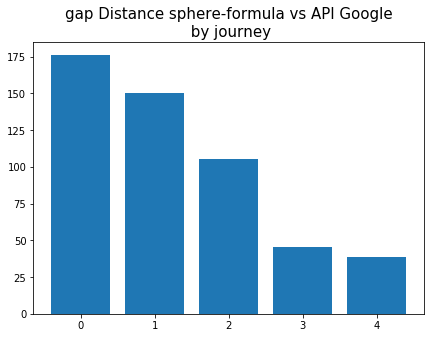

In [7]:
#plot
plt.figure(figsize=(7,5))
plt.bar(random_geocode_df.index,random_geocode_df["DELTA"])
plt.xticks(random_geocode_df.index)
plt.title("gap Distance sphere-formula vs API Google\n by journey", fontsize=15)
plt.show()